In [ ]:
!python --version

Python 3.7.3


In [ ]:
# Start writing your code here...

In [ ]:
!pip install discretize

     |████████████████████████████████| 587 kB 3.3 MB/s eta 0:00:01
  Using cached Cython-0.29.14-cp37-cp37m-manylinux1_x86_64.whl (2.1 MB)
Processing /home/jovyan/.cache/pip/wheels/56/7f/6a/cd60cafbc911ca7f4a69b56b1b488b3883a03a69c574fc24c9/pymatsolver-0.1.2-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/d8/fa/a3/e4a62089a729df0ed67f551333091b4f9c82abcff7f119adf6/properties-0.6.1-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/77/de/1d/ba66341d4294034c3766c87fcd84119a4a6642db106cda0803/vectormath-0.2.2-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/81/04/ab/16d8283a3d13287e586d9fc14df7d9ff36c810f4bbb5d03146/pyMKL-0.0.3-py3-none-any.whl
Processing /home/jovyan/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0/future-0.18.2-py3-none-any.whl
  Created wheel for discretize: filename=discretize-0.4.11-cp37-cp37m-linux_x86_64.whl size=2217009 sha256=c37d55d1204a1a81c6fc62b39fc1aa694b700c65df5cfa4e8ea6c16d05b6148f
  Stored in dir

In [ ]:
# Insert code hfrom discretize import TensorMesh
from discretize import TensorMesh
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# GLOBAL VARIABLES
# Materials
class gas():
    def __init__(self):
        self.density = 1.15e-9
        self.conductivity = 0.024e-3
        self.viscosity = 1.7e-5
        self.capacity = 720
        self.velocity = 50e6 / (np.pi * (27)**2)
        self.cordieriteC = 2
        self.steelC = 2

gas = gas()

class steel():
    def __init__(self):
        self.density = 8030e-9
        self.conductivity = 16.3e-3
        self.airC = 2e-6
        self.gasC = 2e-6
        self.coerdieriteC = np.infty
        
    def capacity(self, T):
        return 450 + 0.28 * T

steel = steel()

class cordierite():
    def __init__(self):
        self.density = 2300e-9
        self.conductivity = 2.5e-3
        self.capacity = 900
        self.thickness = 10
        self.steelR = np.infty
        self.gasC = 2e-6
        self.airC = 2e-6

cordierite = cordierite()

boundaryConductivity = 2e-6

# Temperatures
Tair = 25 +273
T0 = 25 + 273
Tgas = 300 +273
#Tcatalyst = 150

# Dimensions (all in mm)
class pipe():
    def __init__(self):
        self.thickness = 1
        self.outerRadius = 28 #56 * 0.5
        self.innerRadius = self.outerRadius - self.thickness
        self.length = 100 #100
pipe = pipe()

class air():
    def __init__(self):
        self.conductivity = np.infty
        self.capacity = np.infty
        self.density = 1.
air = air()

class substrate():
    def __init__(self):
        self.length = 1 #10
        self.thickness = 1
        self.channel = 4
substrate = substrate()



# Discretization setup
dz = 1 # volume elements of 1 micrometer size (in mm) 1e-6 * 10e3
dr = dz # volume elememts are cubes

# Space (2D)
zspace = int(pipe.length / dz) # elements in longitudinal direction
rspace = int(pipe.outerRadius / dr) # elements in radial direction

In [ ]:
ncx = rspace     # number of core mesh cells in x
ncy = rspace     # number of core mesh cells in y
ncz = zspace     # number of core mesh cells in z
dx = 1.      # base cell width x
dy = 1.      # base cell width y
dz = 1.      # base cell width z
hx = dx*np.ones(ncx)
hy = dy*np.ones(ncy)
hz = dz*np.ones(ncz)
dt = dz/gas.velocity #in order to move dz every time step
x0 = 0
y0 = 0
z0 = 0

mesh = TensorMesh([hx, hz], x0=[x0, z0])
cx = (mesh.vectorCCx)
cz = (mesh.vectorCCy)
Mesh = TensorMesh([hx,hy], x0 = [x0, y0])
Cx = (Mesh.vectorCCx)
Cy = (Mesh.vectorCCy)


In [ ]:
def materialSpacexz(n):

# Defining material in space (air = 0, gas = 1, pipe = 2, cordieritee = 3)
    materialSpace = np.full((rspace+2, zspace+2), 0) # fill all space with air
    if n> 0:
        materialSpace[1:rspace+2,0] = 1 #add initial layer of gas
    materialSpace[2:rspace+2,1:n+1] = 1 #add gas in pipe
    MaterialSpace = materialSpace[1:-1,1:-1]
    for i in range(int(substrate.thickness/dz),rspace):
        for j in range(zspace-cordierite.thickness,zspace): 
            if (rspace-i-1+dx/2+2.5)%5 == 0:
                MaterialSpace[i, j] = 3 # overlay cordierite
    materialSpace[1:-1,1:-1] = MaterialSpace        
    materialSpace[1:int(pipe.thickness / dz)+1,1:zspace+1] = 2 # overlay pipe
    return materialSpace

In [ ]:
def gasFlow(tempProfile, materialSpace):
    """
        GASFLOW moves all of the gas due to its velocity by updating (shifting) the temperature
        profile of the system. By the setup, the gas moves by one volume element size.
    """
    
    for iz in range(1,zspace+2):
        for ix in range(2,rspace+2):
            if materialSpace[ix,iz] == 1:
                tempProfile[ix,iz] = tempProfile[ix,iz-1] # moves gas downstream by 1 dz
            else:
                continue


    return tempProfile

In [ ]:
n = 1
tempProfile = np.full((rspace+2,zspace+2),T0)
if n> 0 :
    tempProfile[:, 0] = Tgas
materialSpace = materialSpacexz(n)    

In [ ]:
print (materialSpace)

[[0 0 0 ... 0 0 0]
 [1 2 2 ... 2 2 0]
 [1 1 0 ... 0 0 0]
 ...
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]]


In [ ]:
print (gasFlow(tempProfile, materialSpace))

[[573 298 298 ... 298 298 298]
 [573 298 298 ... 298 298 298]
 [573 573 298 ... 298 298 298]
 ...
 [573 573 298 ... 298 298 298]
 [573 573 298 ... 298 298 298]
 [573 573 298 ... 298 298 298]]


In [ ]:
def propertySpace(tempProfile, materialSpace):
    T = tempProfile
    densitySpace = np.full((rspace+2, zspace+2), 1.)
    kSpace = np.full((rspace+2, zspace+2), 1.)
    capacitySpace = np.full((rspace+2, zspace+2), 1.)
    
    for i in range(rspace+2):
        for j in range(zspace+2):
            if materialSpace[i,j] == 1: #gas
                kSpace[i,j] = gas.conductivity
                densitySpace[i,j] = gas.density
                capacitySpace[i,j] = gas.capacity
            elif materialSpace[i,j] == 2: #steel
                kSpace[i,j] = steel.conductivity
                densitySpace[i,j] = steel.density   
                capacitySpace[i,j] = steel.capacity(T[i,j]-273)
            elif materialSpace[i,j] == 3: #cordierite
                kSpace[i,j] = cordierite.conductivity
                densitySpace[i,j] = cordierite.density
                capacitySpace[i,j] = cordierite.capacity
            elif materialSpace[i,j] == 0: #air
                kSpace[i,j] = air.conductivity
                densitySpace[i,j] = air.density
                capacitySpace[i,j] = air.capacity
    return kSpace, densitySpace, capacitySpace

In [ ]:
def dTProfile(tempProfile):
    """
    array of dT values at given time
    """
    
    dT1 = np.full((rspace, zspace), 0.)
    dT2 = np.full((rspace, zspace), 0.)
    dT3 = np.full((rspace, zspace), 0.)
    dT4 = np.full((rspace, zspace), 0.)

    for ix in range (rspace):
        for iz in range (zspace):
            Tn = tempProfile.copy()
            dT1[ix,iz] = Tn[ix-1+1,iz+1] - Tn[ix+1,iz+1]
            dT2[ix,iz] = Tn[ix+1+1,iz+1] - Tn[ix+1,iz+1]
            dT3[ix,iz] = Tn[ix+1,iz+1+1] - Tn[ix+1,iz+1]
            dT4[ix,iz] = Tn[ix+1,iz-1+1] - Tn[ix+1,iz+1]
                        
    return dT1,dT2,dT3,dT4  

In [ ]:
print (tempProfile)

[[573 298 298 ... 298 298 298]
 [573 298 298 ... 298 298 298]
 [573 573 298 ... 298 298 298]
 ...
 [573 573 298 ... 298 298 298]
 [573 573 298 ... 298 298 298]
 [573 573 298 ... 298 298 298]]


In [ ]:
dT1,dT2,dT3,dT4  = dTProfile(tempProfile)
dT = dT1+dT2+dT3+dT4
print (dT)

[[ 550.    0.    0. ...    0.    0.    0.]
 [-550.  275.    0. ...    0.    0.    0.]
 [-275.  275.    0. ...    0.    0.    0.]
 ...
 [-275.  275.    0. ...    0.    0.    0.]
 [-275.  275.    0. ...    0.    0.    0.]
 [-275.  275.    0. ...    0.    0.    0.]]


In [ ]:
print (sum(dTProfile(tempProfile)))

[[ 550.    0.    0. ...    0.    0.    0.]
 [-550.  275.    0. ...    0.    0.    0.]
 [-275.  275.    0. ...    0.    0.    0.]
 ...
 [-275.  275.    0. ...    0.    0.    0.]
 [-275.  275.    0. ...    0.    0.    0.]
 [-275.  275.    0. ...    0.    0.    0.]]


In [ ]:
def Q(tempProfile, materialSpace):
    """
    Q for a given value of time and temperature profile
    """
    #initialise Q
    q = np.full((rspace, zspace), 0.)
    
    dT1,dT2,dT3,dT4  = dTProfile(tempProfile)
    dT = sum(dTProfile(tempProfile))
    L = dx/2 
    A = dx**2
    k = propertySpace(tempProfile, materialSpace)[0]
    for ix in range (rspace):
        for iz in range (zspace):
            k0 = k[ix+1,iz+1]
            k1 = k[ix-1+1,iz+1]
            k2 = k[ix+1+1,iz+1]
            k3 = k[ix+1,iz+1+1]
            k4 = k[ix+1,iz-1+1]
            
            if materialSpace[ix+2, iz+1] != materialSpace[ix+1, iz+1]:
                if materialSpace[ix+2, iz+1] + materialSpace[ix+1, iz+1] in range(2,5):
                    C2 = boundaryConductivity
                else:
                    C2 = np.infty
            else:
                C2 = np.infty

            if materialSpace[ix, iz+1] != materialSpace[ix+1, iz+1]:
                if materialSpace[ix, iz+1] + materialSpace[ix+1, iz+1] in range(2,5):
                    C1 = boundaryConductivity
                else:
                    C1 = np.infty
            else:
                C1 = np.infty

            if materialSpace[ix+1, iz+2] != materialSpace[ix+1, iz+1]:
                if materialSpace[ix+1, iz+2] + materialSpace[ix+1, iz+1] in range(2,5):
                    C3 = boundaryConductivity
                else:
                    C3 = np.infty
            else:
                C3 = np.infty

            if materialSpace[ix+1, iz] != materialSpace[ix+1, iz+1]:
                if materialSpace[ix+1, iz] + materialSpace[ix+1, iz+1] in range(2,5):
                    C4 = boundaryConductivity
                else:
                    C4 = np.infty 
            else:
                C4 = np.infty
            
        
            
            
            #a1,a2,a3,a4 = dT1[ix,iz],dT2[ix,iz],dT3[ix,iz],dT4[ix,iz]

            if materialSpace[ix+1, iz+1] != 0:
                q[ix,iz] = (dT1[ix,iz]/(L/(k0*A)+L/(k1*A)+1/C1) + dT2[ix,iz]/(L/(k0*A)+L/(k2*A)+1/C2) 
                + dT3[ix,iz]/(L/(k0*A)+L/(k3*A)+1/C3) + dT4[ix,iz]/(L/(k0*A)+L/(k4*A)+1/C4))
            else:
                q[ix,iz] = 0
            
    return q
                
                    
                    
                
            

In [ ]:
print (Q(tempProfile, materialSpace))

[[ 0.00105594  0.          0.         ...  0.          0.
   0.        ]
 [-0.01372797  0.          0.         ...  0.          0.
   0.        ]
 [-0.0132      0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.0132      0.          0.         ...  0.          0.
   0.        ]
 [-0.0132      0.          0.         ...  0.          0.
   0.        ]
 [-0.0132      0.          0.         ...  0.          0.
   0.        ]]


In [ ]:
a = np.infty
print (a/1)

inf


In [ ]:
import math

In [1]:
#don't initialise gas temperature as 300 C at all t. move the changes(new) gas temperature profile

def heatflowz (nt):
    #initialise temperature profile
    tempProfile = np.full((rspace+2,zspace+2),float(T0))
    if nt > 0:
        for n in range(1,nt+1):
            tempProfile[:, 0] = Tgas
            materialSpace = materialSpacexz(n)
            tempProfile = gasFlow(tempProfile, materialSpace)
            kSpace, densitySpace, capacitySpace = propertySpace(tempProfile, materialSpace)
            q = Q(tempProfile,materialSpace)
            aSpace = kSpace/(densitySpace*capacitySpace)
            aSpace = np.nan_to_num(aSpace)
            dT= sum(dTProfile(tempProfile))
            Tn = np.copy(tempProfile)
            tempProfile[1:-1,1:-1] = Tn[1:-1,1:-1] + dt*(q*aSpace[1:-1,1:-1]/kSpace[1:-1,1:-1] + aSpace[1:-1,1:-1]*(dT-6*Tn[1:-1,1:-1])/dx**2)

    plt.contourf(cz,cx,tempProfile[1:-1,1:-1])                        
   # plt.pcolormesh(X,Z,T)

    return tempProfile[1:-1,1:-1]
    

    

In [ ]:
#define an array of number of exposed surfaces to cordierite (3)


[[298. 298. 298. ... 298. 298. 298.]
 [298. 298. 298. ... 298. 298. 298.]
 [298. 298. 298. ... 298. 298. 298.]
 ...
 [298. 298. 298. ... 298. 298. 298.]
 [298. 298. 298. ... 298. 298. 298.]
 [298. 298. 298. ... 298. 298. 298.]]


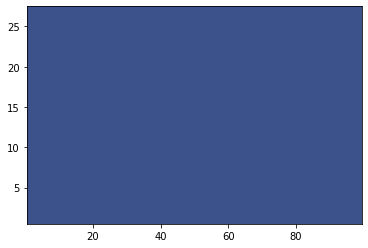

In [ ]:
print (heatflowz (0))

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
[[298.11191211 298.         298.         ... 298.         298.
  298.        ]
 [571.51036229 298.         298.         ... 298.         298.
  298.        ]
 [571.90467689 298.         298.         ... 298.         298.
  298.        ]
 ...
 [571.90467689 298.         298.         ... 298.         298.
  298.        ]
 [571.90467689 298.         298.         ... 298.         298.
  298.        ]
 [571.90467689 298.         298.         ... 298.         298.
  298.        ]]


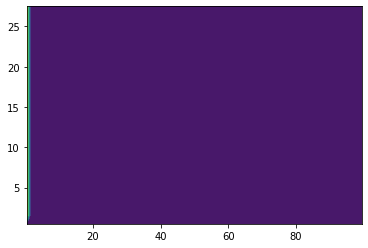

In [ ]:
print (heatflowz (1))

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
[[303.47587105 300.73979351 300.65845259 ... 298.         298.
  298.        ]
 [572.6133834  572.60953386 572.60941868 ... 298.         298.
  298.        ]
 [573.         573.         573.         ... 298.         298.
  298.        ]
 ...
 [573.         573.         573.         ... 298.         298.
  298.        ]
 [573.         573.         573.         ... 298.         298.
  298.        ]
 [573.         573.         573.         ... 298.         298.
  298.        ]]


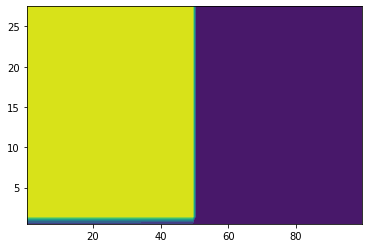

In [ ]:
print (heatflowz (50))

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
[[308.71898504 303.52525756 303.36961282 ... 298.16781684 298.11191017
  298.05597883]
 [572.62090783 572.61352822 572.6133078  ... 572.60584587 572.60576567
  571.51036229]
 [573.         573.         573.         ... 573.         573.
  571.90467689]
 ...
 [573.         573.         573.         ... 298.09134025 298.060898
  298.03045237]
 [573.         573.         573.         ... 572.60578221 572.60573856
  571.51037178]
 [573.         573.         573.         ... 573.         573.
  571.90467689]]


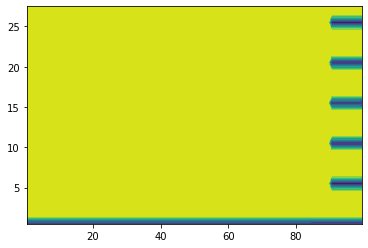

In [ ]:
print (heatflowz (100))

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
[[327.61688663 314.47461895 313.66570964 ... 308.86955506 308.81323644
  308.56435464]
 [572.64802749 572.62923083 572.62807715 ... 572.62119751 572.62111683
  572.62076261]
 [573.         573.         573.         ... 573.         573.
  573.        ]
 ...
 [573.         573.         573.         ... 304.1125359  304.08276746
  304.0536335 ]
 [573.         573.         573.         ... 572.61441658 572.61437389
  572.61433211]
 [573.         573.         573.         ... 573.         573.
  573.        ]]


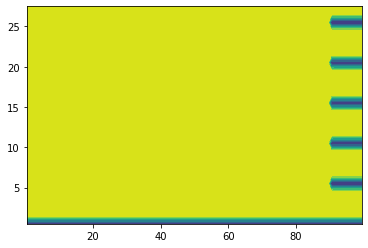

In [ ]:
print (heatflowz (300))

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
[[454.51355392 430.36660608 420.86838845 ... 413.14781182 408.15009953
  392.22533722]
 [572.83009712 572.79547139 572.78185164 ... 572.77078229 572.76361748
  572.74078574]
 [573.         573.         573.         ... 573.         573.
  573.        ]
 ...
 [573.         573.         573.         ... 413.20984466 413.19350644
  413.18188628]
 [573.         573.         573.         ... 572.77086163 572.7708382
  572.77082154]
 [573.         573.         573.         ... 573.         573.
  573.        ]]


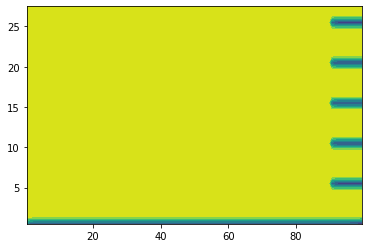

In [ ]:
print (heatflowz (5000))

In [ ]:
def materialSpacexy(z, t):
    """
    Returns material distribution at given z value and time
    """
    materialSpacexy = np.full((rspace, rspace), 0) #fill all space with air
    for ix in range(rspace):
        for iy in range(rspace):
            if Cx[rspace-1-ix]**2 + Cy[iy]**2 >= 28**2:
                materialSpacexy[rspace-1-ix,iy] = 0
            elif Cx[rspace-1-ix]**2 + Cy[iy]**2 >27.**2 and Cx[rspace-1-ix]**2 + Cy[iy]**2 <28.**2:
                if z in range(pipe.length):
                    materialSpacexy[ix,iy] = 2
                else:
                    materialSpacexy[rspace-1-ix,iy] = 0

            else:
                if z in range(pipe.length-cordierite.thickness):
                    materialSpacexy[ix,iy] = 1
                elif z in range(pipe.length-cordierite.thickness,pipe.length):
                    if (Cx[rspace-1-ix]-2.5)%5 == 0:
                        materialSpacexy[ix,iy] = 3
                    elif (Cy[iy]-2.5)%5 == 0:
                        materialSpacexy[ix,iy] = 3
                    else:
                        if gas.velocity*t > z:
                            materialSpacexy[ix,iy] = 1
                        else:
                            materialSpacexy[ix,iy] = 0
                else:
                    if gas.velocity*t > z:
                        materialSpacexy[ix,iy] = 1
                    else:
                        materialSpacexy[ix,iy] = 0
                    
    return materialSpacexy

In [ ]:
def gasFlowxy(z, t):
    xy = materialSpacexy(z,t)
    tempProfilexy = np.full((rspace, rspace), 0.)
    for ix in range(rspace):
        for iy in range(rspace):
            
            if xy[ix,iy] == 0:
                tempProfilexy[ix,iy] = Tair
            if xy[ix,iy] == 1:
                tempProfilexy[ix,iy] = Tgas
            if xy[ix,iy] == 2:
                tempProfilexy[ix,iy] = Tair
            if xy[ix,iy] == 3:
                tempProfilexy[ix,iy] = Tair
                
    return tempProfilexy